<a href="https://colab.research.google.com/github/formroller/ML_clone/blob/master/kaggle/HousePrice/HousePrice_Predict(ko)5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

캐글 집 값 예측 5회차
 > 아이오와주 에임스에 있는 주거용 주택의 모든 측면을 설명하는 81개 변수로 주택 판매가격을 예측하는 Competition.

 **커널 순서**
 1. Import & Data Check
  - 데이터 확인
  - 이상치 탐색 및 제거
  - 비대칭도(Skewness) 확인

2. EDA
 * 수치형 변수 탐색
    - Correlation Heatmap
    - Zoomed Heatmap
    - Pair Plot
    - Scatter Plot
 * 범주형 변수 탐색
    - Violin Plot

3. Feature Engineering
 * Log 변환
    - 변환 전
    - 변환 후
 * 결측치 처리
 * 유의하지 않은 변수 삭제
 * 범주형 변수 수치형으로 변환
    - Violin Plot
    - Heatmap

4. Modeling & Make Submission
 * Validation
 * Modeling
 * Predict
 * KFold
 * Submission

# 1.import & Data Check

In [1]:
import os
os.chdir('/content/drive/MyDrive/kaggle/HousePrice')

import pandas as pd
import numpy as np
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
sns.set(font_scale=1.5)

import missingno as msno
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics
import xgboost

In [2]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
# 데이터 형태 파악
print(train.shape, test.shape, '\n')

# 명목, 수치형 변수 갯수 파악
num_feats=train.dtypes[train.dtypes != 'object'].index
print(f"Number of Numerical Features : {len(num_feats)}")

cate_feats=train.dtypes[train.dtypes == 'object'].index
print(f"Number of Categorical Features : {len(cate_feats)}")

(1460, 81) (1459, 80) 

Number of Numerical Features : 38
Number of Categorical Features : 43


In [5]:
# 변수 형태별 변수명 확인
print(train[num_feats].columns)
print('*'*80)
print(train[cate_feats].columns)

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')
********************************************************************************
Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual'

## 1-1. 이상치 탐색 및 제거

In [6]:
def detect_outlier(df, n, features):
    outlier_indices=[]
    for col in features:
        Q1=np.percentile(df[col],25)
        Q3=np.percentile(df[col],75)
        IQR=Q3-Q1 # 수치형 변수 별 IQR
    
        outlier_step=1.5*IQR
        outlier_list_col=df[(df[col] < Q1 - outlier_step)|(df[col] > Q3 + outlier_step)].index # IQR 범위 넘긴 이상치 인덱스 탐색
        outlier_indices.extend(outlier_list_col)
    
    outlier_indices=Counter(outlier_indices)
    multiple_outliers=list(k for k,v in outlier_indices.items() if v > n) # 이상치 값이 n이상인 인덱스 선택
    return multiple_outliers

Outlier_to_drop=detect_outlier(train, 2, num_feats[:-1])

# 이상치 발견된 행 확인
train.loc[Outlier_to_drop]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
48,49,190,RM,33.0,4456,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,2fmCon,2Story,4,5,1920,2008,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,736,736,GasA,...,Y,SBrkr,736,716,0,1452,0,0,2,0,2,3,TA,8,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,N,0,0,102,0,0,0,NaN,NaN,NaN,0,6,2009,New,Partial,113000
93,94,190,C (all),60.0,7200,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,OldTown,Norm,Norm,2fmCon,2.5Unf,6,6,1910,1998,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,BrkTil,TA,Fa,Mn,Rec,1046,Unf,0,168,1214,GasW,...,N,SBrkr,1260,1031,0,2291,0,1,2,0,4,2,TA,9,Typ,1,Gd,Detchd,1900.0,Unf,2,506,TA,TA,Y,0,0,0,0,99,0,NaN,NaN,NaN,0,11,2007,WD,Normal,133900
125,126,190,RM,60.0,6780,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,2fmCon,1.5Fin,6,8,1935,1982,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,Fa,CBlock,TA,TA,Av,GLQ,490,Unf,0,30,520,GasA,...,N,SBrkr,520,0,234,754,1,0,1,0,2,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,N,53,0,0,0,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal,84500
165,166,190,RL,62.0,10106,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,2fmCon,1.5Fin,5,7,1940,1999,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,Gd,BrkTil,TA,TA,No,ALQ,351,Rec,181,112,644,GasA,...,Y,SBrkr,808,547,0,1355,1,0,2,0,4,2,TA,6,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,Y,140,0,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,127500
172,173,160,RL,44.0,5306,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,2Story,7,7,1987,1987,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,Gd,PConc,Gd,Gd,No,GLQ,495,Rec,215,354,1064,GasA,...,Y,SBrkr,1064,703,0,1767,1,0,2,0,2,1,Gd,5,Typ,1,TA,Attchd,1987.0,RFn,2,504,Gd,TA,Y,441,35,0,0,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal,239000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1350,1351,90,RL,91.0,11643,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Artery,Norm,Duplex,2Story,5,5,1969,1969,Gable,CompShg,MetalSd,MetalSd,BrkFace,368.0,TA,TA,CBlock,TA,TA,No,LwQ,500,Unf,0,748,1248,GasA,...,Y,SBrkr,1338,1296,0,2634,1,1,2,2,6,2,TA,12,Typ,0,NaN,Detchd,1969.0,Unf,4,968,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,8,2009,WD,Normal,200000
634,635,90,RL,64.0,6979,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,Duplex,SFoyer,6,5,1980,1980,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,CBlock,TA,TA,No,GLQ,1056,Unf,0,0,1056,GasA,...,Y,SBrkr,1056,0,0,1056,2,0,0,0,0,2,TA,4,Typ,0,NaN,Detchd,1980.0,Unf,2,576,TA,TA,Y,264,56,0,0,0,0,NaN,GdPrv,Shed,600,6,2010,WD,Normal,144000
910,911,90,RL,80.0,11600,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Feedr,Norm,Duplex,2Story,5,5,1960,1960,Gable,CompShg,MetalSd,MetalSd,BrkFace,361.0,TA,TA,CBlock,TA,TA,No,Rec,443,Unf,0,662,1105,GasA,...,Y,FuseA,1105,1169,0,2274,0,0,2,0,5,2,TA,12,Typ,0,NaN,Detchd,1960.0,Unf,2,480,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,1,2010,WD,Normal,154300
1292,1293,70,RM,60.0,6600,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,OldTown,Norm,Norm,1Fam,2Story,5,4,1892,1965,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,Stone,TA,TA,

In [7]:
# 이상치를 제거하고 결과 확인
train=train.drop(Outlier_to_drop, axis=0).reset_index(drop=True)
train.shape

# 1460 -> 1338개로 행 감소

(1338, 81)

## 1-2. 결측치 확인

In [8]:
for col in train:
    msper='columns : {:>10} \t Percent of NaN values : {:.2f}%'.format(col, 100*(train[col].isnull().sum()/train[col].shape[0]))
    print(msper)

columns :         Id 	 Percent of NaN values : 0.00%
columns : MSSubClass 	 Percent of NaN values : 0.00%
columns :   MSZoning 	 Percent of NaN values : 0.00%
columns : LotFrontage 	 Percent of NaN values : 17.12%
columns :    LotArea 	 Percent of NaN values : 0.00%
columns :     Street 	 Percent of NaN values : 0.00%
columns :      Alley 	 Percent of NaN values : 94.10%
columns :   LotShape 	 Percent of NaN values : 0.00%
columns : LandContour 	 Percent of NaN values : 0.00%
columns :  Utilities 	 Percent of NaN values : 0.00%
columns :  LotConfig 	 Percent of NaN values : 0.00%
columns :  LandSlope 	 Percent of NaN values : 0.00%
columns : Neighborhood 	 Percent of NaN values : 0.00%
columns : Condition1 	 Percent of NaN values : 0.00%
columns : Condition2 	 Percent of NaN values : 0.00%
columns :   BldgType 	 Percent of NaN values : 0.00%
columns : HouseStyle 	 Percent of NaN values : 0.00%
columns : OverallQual 	 Percent of NaN values : 0.00%
columns : OverallCond 	 Percent of NaN 

* train[col].isnull().sum()
    - 해당 열의 결측치가 몇 개인지 알 수 있다. (True=1 결측치, False=0)
* train[col].shape[0]
    - 해당 열의 차원 출력(열이 지정되어 있으므로 행의 갯수 출력)
* 100*(train[col].isnull.sum()/train[col].shape[0])
    - 컬럼의 결측치(%) 출력

In [9]:
# test 데이터 결측치 확인
for col in test.columns:
    msper='columns : {:>10} \t Percent of NaN Value : {:.2f}%'.format(col, 100*(test[col].isnull().sum()/test[col].shape[0]))
    print(msper)

columns :         Id 	 Percent of NaN Value : 0.00%
columns : MSSubClass 	 Percent of NaN Value : 0.00%
columns :   MSZoning 	 Percent of NaN Value : 0.27%
columns : LotFrontage 	 Percent of NaN Value : 15.56%
columns :    LotArea 	 Percent of NaN Value : 0.00%
columns :     Street 	 Percent of NaN Value : 0.00%
columns :      Alley 	 Percent of NaN Value : 92.67%
columns :   LotShape 	 Percent of NaN Value : 0.00%
columns : LandContour 	 Percent of NaN Value : 0.00%
columns :  Utilities 	 Percent of NaN Value : 0.14%
columns :  LotConfig 	 Percent of NaN Value : 0.00%
columns :  LandSlope 	 Percent of NaN Value : 0.00%
columns : Neighborhood 	 Percent of NaN Value : 0.00%
columns : Condition1 	 Percent of NaN Value : 0.00%
columns : Condition2 	 Percent of NaN Value : 0.00%
columns :   BldgType 	 Percent of NaN Value : 0.00%
columns : HouseStyle 	 Percent of NaN Value : 0.00%
columns : OverallQual 	 Percent of NaN Value : 0.00%
columns : OverallCond 	 Percent of NaN Value : 0.00%
colu

train/test 데이터 모두 **PoolQC** 데이터의 결측치가 높다.

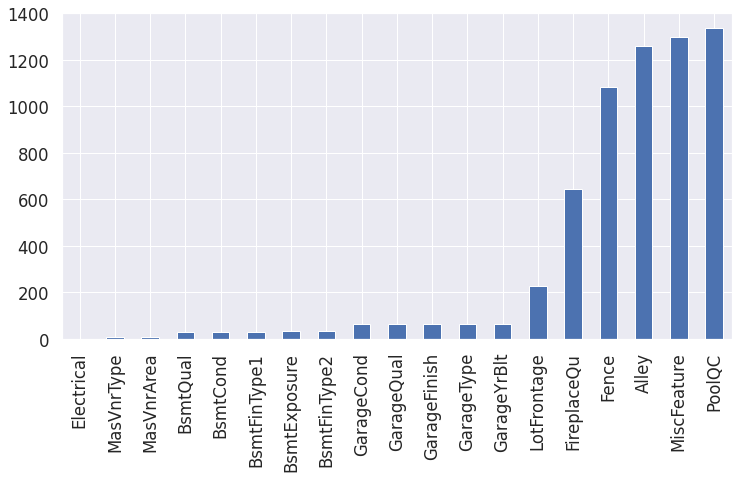

In [10]:
# 결측치 시각화 (Bar Plot)
missing=train.isnull().sum()
missing=missing[missing>0]
missing.sort_values(inplace=True)
missing.plot.bar(figsize=(12,6))

## 1-3. 비대칭도(Skewness) 확인

In [11]:
for col in num_feats[1:]:
    print(f"{col:15} \t Skewness : {train[col].skew():.2f} \t Kurtosis : {train[col].kurt():.2f}")

MSSubClass      	 Skewness : 1.37 	 Kurtosis : 1.49
LotFrontage     	 Skewness : 1.59 	 Kurtosis : 13.04
LotArea         	 Skewness : 7.78 	 Kurtosis : 123.55
OverallQual     	 Skewness : 0.16 	 Kurtosis : -0.05
OverallCond     	 Skewness : 0.74 	 Kurtosis : 1.23
YearBuilt       	 Skewness : -0.58 	 Kurtosis : -0.60
YearRemodAdd    	 Skewness : -0.52 	 Kurtosis : -1.27
MasVnrArea      	 Skewness : 2.69 	 Kurtosis : 11.04
BsmtFinSF1      	 Skewness : 0.65 	 Kurtosis : -0.50
BsmtFinSF2      	 Skewness : 4.86 	 Kurtosis : 26.86
BsmtUnfSF       	 Skewness : 0.87 	 Kurtosis : 0.29
TotalBsmtSF     	 Skewness : 0.29 	 Kurtosis : 1.17
1stFlrSF        	 Skewness : 0.66 	 Kurtosis : 0.02
2ndFlrSF        	 Skewness : 0.77 	 Kurtosis : -0.80
LowQualFinSF    	 Skewness : 12.74 	 Kurtosis : 170.50
GrLivArea       	 Skewness : 0.66 	 Kurtosis : 0.54
BsmtFullBath    	 Skewness : 0.56 	 Kurtosis : -0.96
BsmtHalfBath    	 Skewness : 4.91 	 Kurtosis : 24.68
FullBath        	 Skewness : -0.05 	 Kurtosis :

* 수치형 변수의 비대칭도와(Skewness)와 첨도(Kurtosis)를 확인한다.  
  (이는 분포가 얼마나 비대칭을 나타내는가 알려주는 척도이다.)
    
        비대칭도
        - a = 0, 정규분포
        - a < 0, 오른쪽으로 치우침
        - a > 0, 왼쪽으로 치우침

데이터에서 비대칭도와 첨도를 보이는 변수가 여럿 있으며, 예측값인 SalePrice 역시 약한 비대칭도를 보인다.

# 2.EDA

## 2-1. 수치형 변수 탐색

* Correlation Heatmap
* Zoomed Heatmap
* Pair Plot
* Scatter Plot

### 2-1-a. Correlation Heatmap

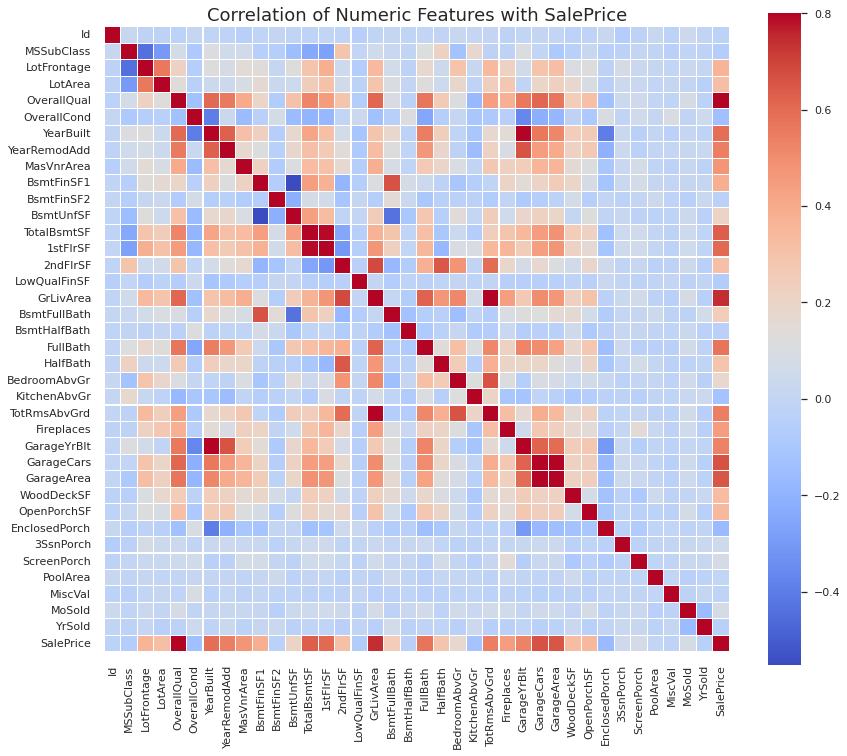

In [12]:
corr_data=train[num_feats]

colormap=plt.cm.coolwarm
sns.set(font_scale=1.0)

f,ax=plt.subplots(figsize=(14,12))
plt.title('Correlation of Numeric Features with SalePrice', y=1, size=18)
sns.heatmap(corr_data.corr(), square=True, linewidths=0.1, cmap=colormap, linecolor='white', vmax=.8)

Heatmap은 직관적이며 변수간 상관관게 및 다중공성선 감지에 유용하다.  
1. 대각선 열을 제외한 박스 중 가장 진한 빨간색을 나타내는 것은 아래와 같다.
 * TotalBstmSF와 1stFlrSF변수는 상관관계가 있다.
 * Garage~ 변수들간 서로 상관관계가 있다고 볼 수 있다.

두 경우 모두 변수 사이의 상관관계가 너무 강한 탓에 다중공성선(MultiColarisity)이 나타난다고 볼 수 있다. 

2. SalePrice와의 상관관계
 * GrLivArea, TotalBsmtSF, OverallQual과 높은 상관관계를 볼 수 있다.

나머지 변수와의 상관관계를 자세히 알아보기 위해 Zoomed Heatmap을 확인해본다.

### 2-1-b. Zoomed Heatmap

Index(['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'YearBuilt', 'FullBath', 'TotRmsAbvGrd',
       'YearRemodAdd'],
      dtype='object')


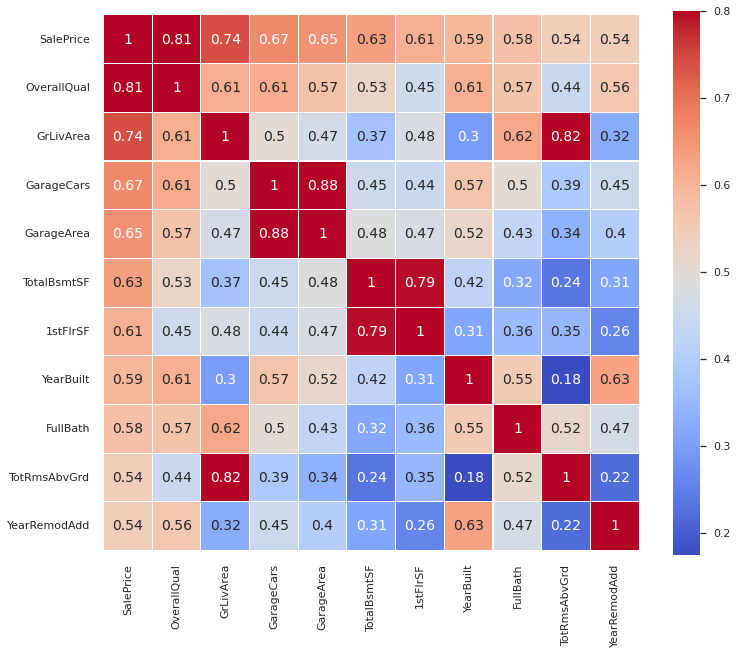

In [13]:
k=11
cols=corr_data.corr().nlargest(k,'SalePrice')['SalePrice'].index
print(cols)
cm=np.corrcoef(train[cols].values.T)
cm=np.corrcoef(train[cols].values.T)

f,ax=plt.subplots(figsize=(12,10))
sns.heatmap(cm, vmax=.8, linewidths=.1, square=True, annot=True, cmap=colormap, 
            linecolor='white', xticklabels=cols.values, annot_kws={'size':14}, yticklabels=cols.values)

* GarageCars/GarageArea, TotalBsmtSF/1stFlrSF는 서로 밀접하게 연관되어 있다.
* OverallQual, GrLivArea, TotalBsmtSF는 종속변수와 밀접한 관계가 있어 보인다. 
*GarageCars/GarageArea, TotalBsmtSF/1stFlrSF, TotalRmsAbvGrd/GrLivArea 변수들은 유사한 정보를 포함하고 있으므로 다중공선성이 나타난다고 볼 수 있다.
* SalePrice와 더 연관된 변수인 GarageCar, TotalBsmtSF, GrLivArea는 남기고 나머지 변수는 제거.

Saleprice와의 연관을 더 알아보기 위해 PairPlot을 그려보자

### 2-1-c. Pair Plot

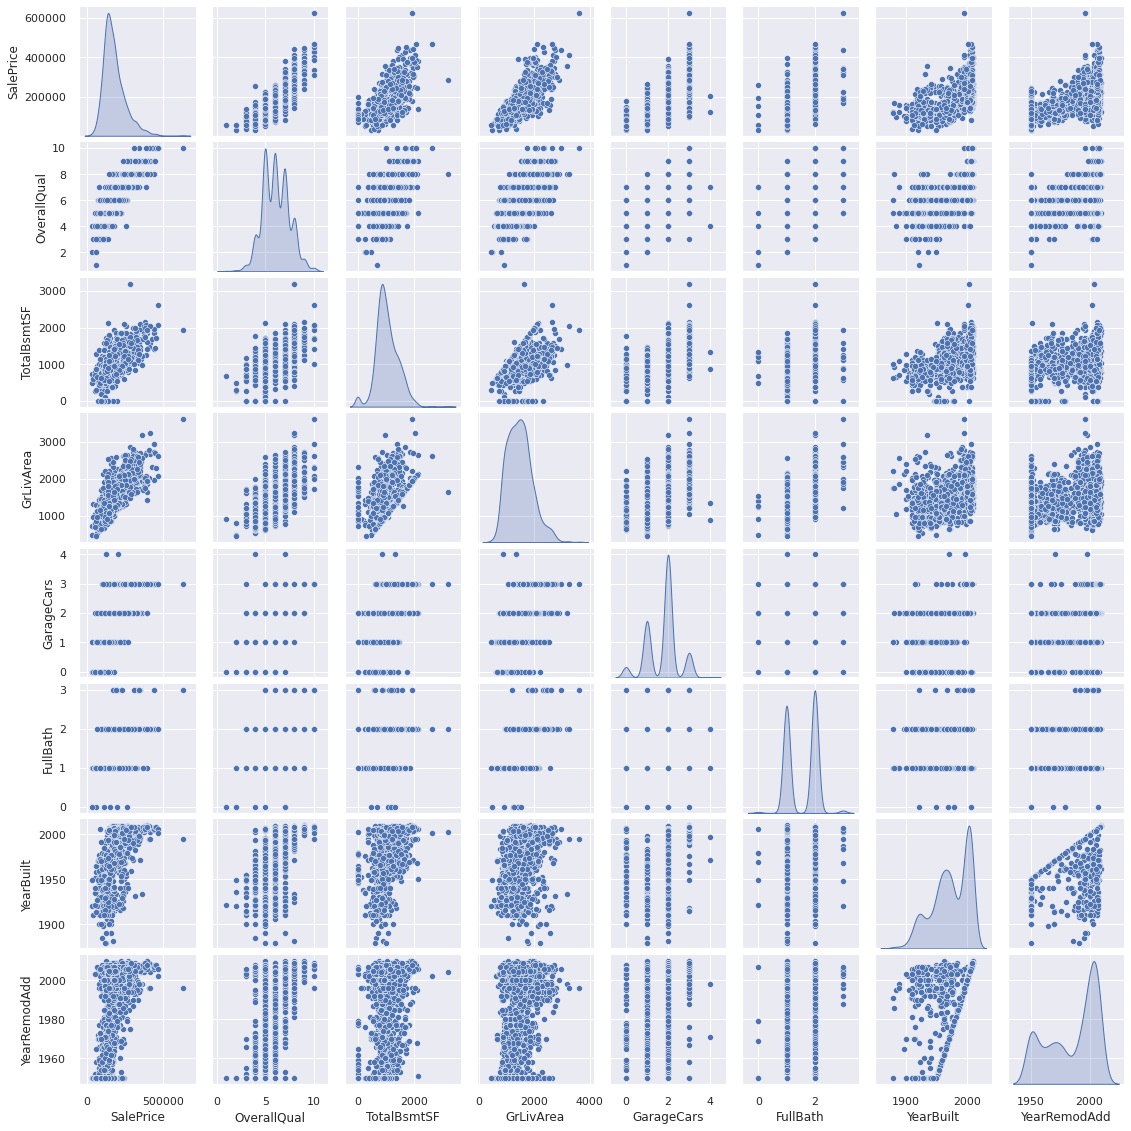

In [14]:
sns.set()
columns=['SalePrice','OverallQual','TotalBsmtSF','GrLivArea','GarageCars','FullBath','YearBuilt','YearRemodAdd']
sns.pairplot(train[columns], size=2, kind='scatter',diag_kind='kde')
plt.show()

## 2-2. 범주형 변수 탐색
질적 변수를 사용해 두 가지 방법을 구현할 수 있다.
1. 변수 값과 관련해 SalePrice의 분포 확인
2. 더미화가 가능한 변수들 변환


In [15]:
for cate in list(cate_feats):
    print(train[cate].value_counts())
    print('*'*50)

RL         1055
RM          197
FV           65
RH           14
C (all)       7
Name: MSZoning, dtype: int64
**************************************************
Pave    1335
Grvl       3
Name: Street, dtype: int64
**************************************************
Grvl    42
Pave    37
Name: Alley, dtype: int64
**************************************************
Reg    859
IR1    440
IR2     32
IR3      7
Name: LotShape, dtype: int64
**************************************************
Lvl    1211
Bnk      52
HLS      48
Low      27
Name: LandContour, dtype: int64
**************************************************
AllPub    1338
Name: Utilities, dtype: int64
**************************************************
Inside     972
Corner     235
CulDSac     81
FR2         46
FR3          4
Name: LotConfig, dtype: int64
**************************************************
Gtl    1275
Mod      56
Sev       7
Name: LandSlope, dtype: int64
**************************************************
NAmes      20

### 2-2-a. Violin Plot

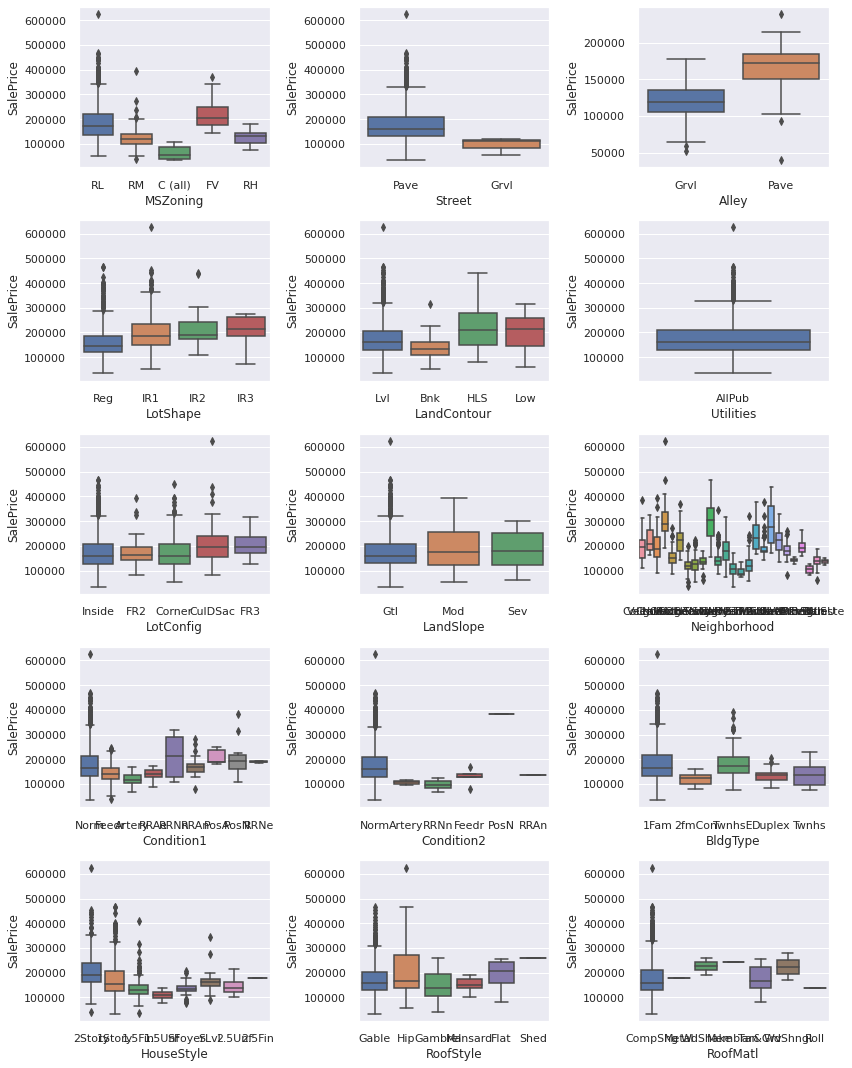

In [16]:
li_cate_feats=list(cate_feats)
nr_rows=5
nr_cols=3

fig, axs=plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*4, nr_rows*3))

for r in range(0, nr_rows):
    for c in range(0, nr_cols):
        i = r* nr_cols + c
        if i < len(li_cate_feats):
            sns.boxplot(x=li_cate_feats[i], y=train['SalePrice'], data=train, ax=axs[r][c])

plt.tight_layout()
plt.show()

Box Plot을 그려 범주형 변수와 SalePrice의 관계를 확인한다. 
* Neighborhood 변수는 주택 가격에 대해 편가차 큼으로 서로 관계가 있어 보인다.
* SaleType 또한 주택 가격에 대해 편차가 크다.
* 수영장의 유무가 주택 가격에 영향을 미친다.

In [30]:
# 편의를 위해 SalePrice와 관련이 큰 변수와 작은 변수를 분리한다. 
# Id는 submission을 위해 별도로 분리한다.
num_strong_corr=['SalePrice','OverallQual','TotalBsmtSF','GrLivArea','GarageCars',
                 'FullBath','YearBuilt','YearRemodAdd']

num_weak_corr=['MSSubClass', 'LotFrontage', 'LotArea', 'OverallCond', 'MasVnrArea', 'BsmtFinSF1',
                 'BsmtFinSF2', 'BsmtUnfSF', '1stFlrSF', '2ndFlrSF','LowQualFinSF', 'BsmtFullBath',
                 'BsmtHalfBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
                 'Fireplaces', 'GarageYrBlt', 'GarageArea', 'WoodDeckSF','OpenPorchSF',
                 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']

cate_strong_corr=['MSZoning','Neighborhood','Condition2','MasVnrType', 'ExterQual',
                  'BsmtQual','CentralAir','Electrical','KitchenQual','SaleType']

cate_weak_corr=['Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 
                  'LandSlope', 'Condition1',  'BldgType', 'HouseStyle', 'RoofStyle', 
                  'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterCond', 'Foundation', 
                  'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 
                  'HeatingQC', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 
                  'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 
                  'SaleCondition']

# 3.Feature Engineering

## 3-1.Log 변환

### 3-1-a. 변환 전

Skewness : 1.287364
Kurtosis : 2.555029


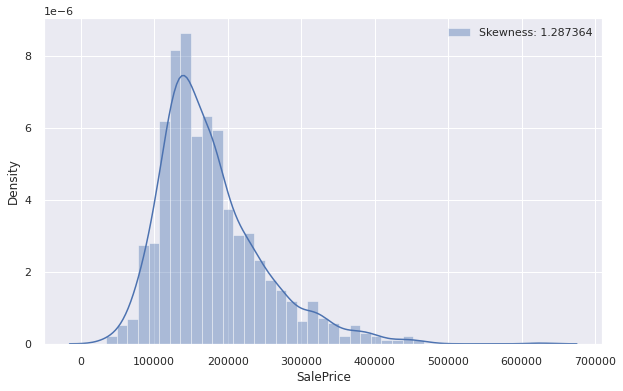

In [18]:
f, ax = plt.subplots(1,1,figsize=(10,6))
g=sns.distplot(train['SalePrice'], color='b', label='Skewness: {:2f}'.format(train['SalePrice'].skew()), ax=ax)
g=g.legend(loc='best')

print(f"Skewness : {train['SalePrice'].skew():.6f}")
print(f"Kurtosis : {train['SalePrice'].kurt():.6f}")

* SalePrice의 비대칭도와 첨도를 확인한다.
* 그래프와 수치를 확인하면 정상적으로 분포되지 않는 것을 알 수 있다.
* 예측의 정확도를 높히기 위해 로그 변환 수행한다.

### 3-1-b. 변환 후

Skewness : -0.032026
Kurtosis : 0.571897


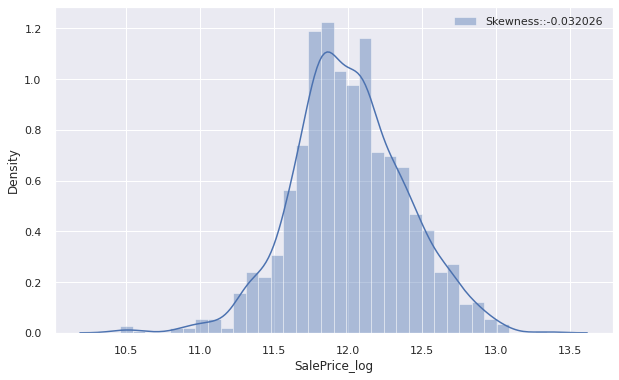

In [19]:
train['SalePrice_log']=train['SalePrice'].map(lambda i : np.log(i) if i > 0 else 0)

f,ax=plt.subplots(1,1, figsize=(10,6))
g=sns.distplot(train['SalePrice_log'], color='b', label='Skewness::{:2f}'.format(train['SalePrice_log'].skew()), ax=ax)
g=g.legend(loc='best')

print(f"Skewness : {train['SalePrice_log'].skew():6f}")
print(f"Kurtosis : {train['SalePrice_log'].kurt():6f}")

train.drop('SalePrice' ,axis=1, inplace=True)

* Skewness, Kurtosis를 없애주기 위해 로그를 취한다.
* Log 변환을 위해 SalePrice_log 변수를 만들고 기존의 SalePrice 변수는 제거한다.
* 로그를 취한 후 그래프의 수치가 바뀐 모습을 볼 수 있다.(정규근사화)

Data Check 과정에서 봤을 때 왜도와 첨도가 보이는 변수가 여럿 있었으나, EDA 과정에서 중요하다고 판단된 수치형 변수들은 왜도와 첨도가 보이지 않으므로 SalePrice만 Log를 취한다.

## 3-2. 결측치 처리
집 값 예측 문제에는 굉장히 많은 결측치(NaN)가 포함되어 있고 이들은 자료의 유/무 만을 나타낸다. 이러한 변수들의 특징을 파악해 결측 데이터를 처리하도록 한다.

In [20]:
# 결측치(Nan)는 '없다'의 의미와 값을 갖는 변수이며, 이들을 None으로 대체한다.
cols_fillna=['PoolQC','MiscFeature','Alley','Fence','MasVnrType','FireplaceQu',
             'GarageQual','GarageCond','GarageFinish','GarageType', 'Electrical',
             'KitchenQual', 'SaleType', 'Functional', 'Exterior2nd', 'Exterior1st',
             'BsmtExposure','BsmtCond','BsmtQual','BsmtFinType1','BsmtFinType2',
             'MSZoning', 'Utilities']

for col in cols_fillna:
    train[col].fillna('None',inplace=True)
    test[col].fillna('None',inplace=True)

In [24]:
# 결측치 처리 정도 확인
total=train.isnull().sum().sort_values(ascending=False)
percent=(train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)

missing_data=pd.concat([total, percent], axis=1, keys=['Total','Percent'])
missing_data.head()

,Total,Percent
LotFrontage,229,0.171151
GarageYrBlt,65,0.048580
MasVnrArea,7,0.005232
SalePrice_log,0,0.000000
ExterCond,0,0.000000


In [26]:
# 나머지 값은 평균으로 대체
train.fillna(train.mean(), inplace=True)
test.fillna(test.mean(), inplace=True)

# 다시 확인하면 결측치가 사라진 것을 알 수 있다.
total=train.isnull().sum().sort_values(ascending=False)
percent=(train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)

missing_data=pd.concat([total, percent],axis=1, keys=['Total','Percent'])

In [27]:
train.isnull().sum().sum(), test.isnull().sum().sum()

(0, 0)

## 3-3. 유의하지 않은 변수 삭제

In [32]:
# SalePrice와 상관관계가 약한 모든 변수 삭제
id_test=test['Id']

to_drop_num=num_weak_corr
to_drop_cate=cate_weak_corr
cols_to_drop = ['Id'] + to_drop_num + to_drop_cate

for df in [train,test]:
    df.drop(cols_to_drop, inplace=True, axis=1)

train.head()

,MSZoning,Neighborhood,Condition2,OverallQual,YearBuilt,YearRemodAdd,MasVnrType,ExterQual,BsmtQual,TotalBsmtSF,CentralAir,Electrical,GrLivArea,FullBath,KitchenQual,GarageCars,SaleType,SalePrice_log
0,RL,CollgCr,Norm,7,2003,2003,BrkFace,Gd,Gd,856,Y,SBrkr,1710,2,Gd,2,WD,12.247694
1,RL,Veenker,Norm,6,1976,1976,None,TA,Gd,1262,Y,SBrkr,1262,2,TA,2,WD,12.109011
2,RL,CollgCr,Norm,7,2001,2002,BrkFace,Gd,Gd,920,Y,SBrkr,1786,2,Gd,2,WD,12.317167
3,RL,Crawfor,Norm,7,1915,1970,None,TA,TA,756,Y,SBrkr,1717,1,Gd,3,WD,11.849398
4,RL,NoRidge,Norm,8,2000,2000,BrkFace,Gd,Gd,1145,Y,SBrkr,2198,2,Gd,3,WD,12.429216


 ## 3-4. 범주형 변수 수치형으로 전환
 EDA의 BoxPlot에서 종속변수와 영향이 큰 변수들을 반환한다.

### 3-4-a. Violin Plot

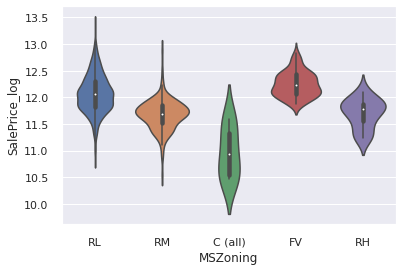

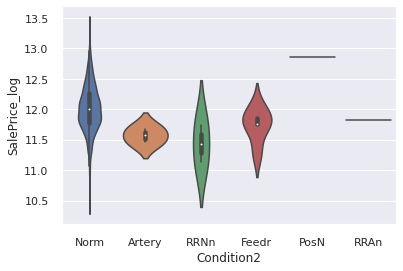

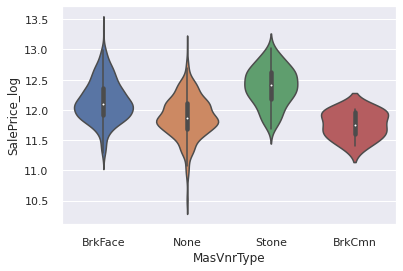

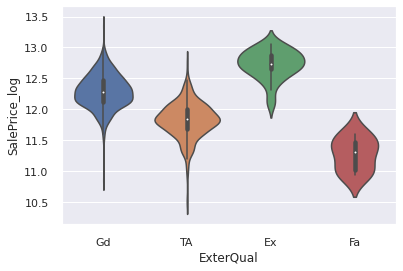

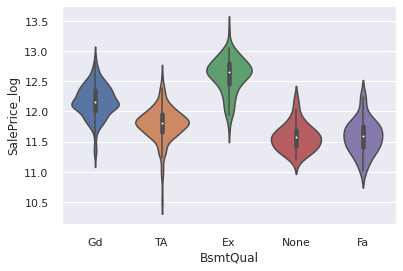

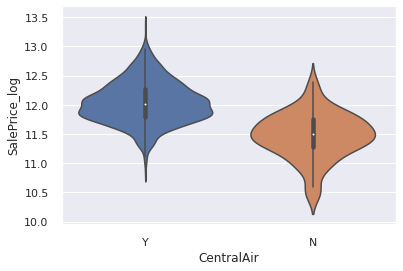

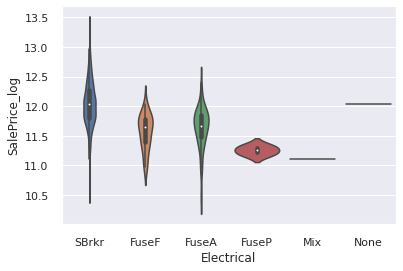

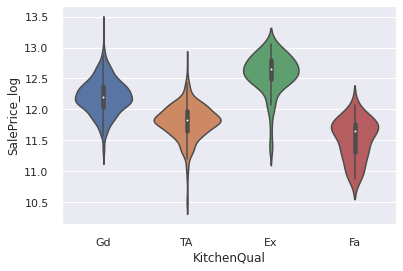

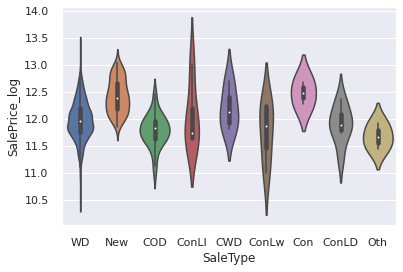

In [33]:
cate_list=cate_strong_corr.copy()
cate_list.remove('Neighborhood')

for cate in cate_list:
    sns.violinplot(x=cate, y=train['SalePrice_log'], data=train)
    plt.show()

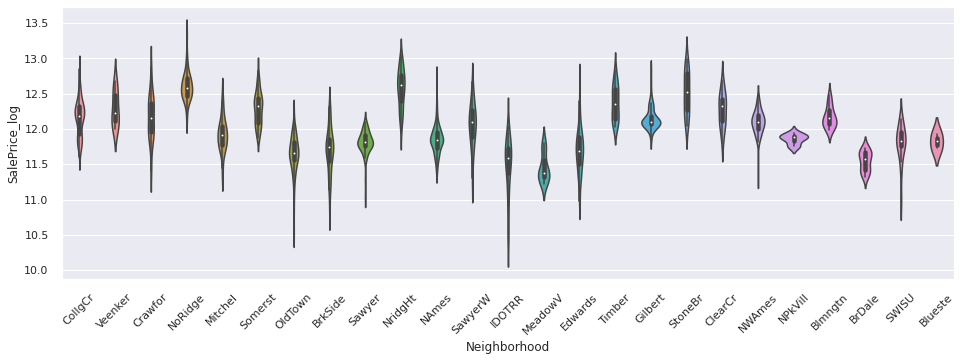

In [34]:
# 범주가 가장 많은 Neighborhood 변수도 확인
fig, ax = plt.subplots()
fig.set_size_inches(16,5)
sns.violinplot(x='Neighborhood',y=train['SalePrice_log'], data=train, ax=ax)
plt.xticks(rotation=45)
plt.show()

In [35]:
for cate in cate_list:
    g=train.groupby(cate)['SalePrice_log'].mean()
    print(g)

MSZoning
C (all)    10.960733
FV         12.246616
RH         11.700602
RL         12.069474
RM         11.677434
Name: SalePrice_log, dtype: float64
Condition2
Artery    11.570036
Feedr     11.734675
Norm      12.012766
PosN      12.860999
RRAn      11.827043
RRNn      11.435329
Name: SalePrice_log, dtype: float64
MasVnrType
BrkCmn     11.757397
BrkFace    12.150038
None       11.884715
Stone      12.391766
Name: SalePrice_log, dtype: float64
ExterQual
Ex    12.727937
Fa    11.274881
Gd    12.295102
TA    11.828332
Name: SalePrice_log, dtype: float64
BsmtQual
Ex      12.595497
Fa      11.585725
Gd      12.170320
None    11.572903
TA      11.791989
Name: SalePrice_log, dtype: float64
CentralAir
N    11.471479
Y    12.042717
Name: SalePrice_log, dtype: float64
Electrical
FuseA    11.641350
FuseF    11.565700
FuseP    11.256345
Mix      11.112448
None     12.028739
SBrkr    12.047595
Name: SalePrice_log, dtype: float64
KitchenQual
Ex    12.582467
Fa    11.514567
Gd    12.209558
TA    11.

In [37]:
# 수치형 변환을 위해 ViolinPlot과 SalePrice_log 평균을 참고해 범주형 변수를 그룹화한다.

# MSZoning
msz_cate2=['RM','RH']
msz_cate3=['RL','FV']

# Neighborhood
nbhd_cate2=['Blmngtn','ClearCr','CollgCr','Crawfor','Gilbert','NWAmes','Somerst','Timber','Veenker']
nbhd_cate3=['NoRidge','NridgHt','StoneBr']

# Condition2
cond2_cate2=['Norm','RRAe']
cond2_cate3=['Posa','PosN']

# SaleType
SlTy_cate1=['Oth']
SlTy_cate3=['CWD']
SlTy_cate4=['New','Con']

In [38]:
# 범주형 변수를 수치형으로 변환
for df in [train, test]:
    df['MSZ_num']=1
    df.loc[(df['MSZoning'].isin(msz_cate2) ), 'MSZ_num']=2 
    df.loc[(df['MSZoning'].isin(msz_cate3) ), 'MSZ_num']=3

    df['nbHd_num']=1
    df.loc[(df['Neighborhood'].isin(nbhd_cate2)),'nbHd_num']=2
    df.loc[(df['Neighborhood'].isin(nbhd_cate3)),'nbHd_num']=3

    df['Cond2_num']=1
    df.loc[(df['Condition2'].isin(cond2_cate2)),'Cond2_num']=2
    df.loc[(df['Condition2'].isin(cond2_cate3)),'Cond2_num']=3

    df['Mas_num']=1
    df.loc[(df['MasVnrType']=='Stone'),'Mas_num']=2
    
    df['ExtQ_num']=1
    df.loc[(df['ExterQual']=='TA'),'ExtQ_num']=2
    df.loc[(df['ExterQual']=='Gd'),'ExtQ_num']=3
    df.loc[(df['ExterQual']=='Ex'),'ExtQ_num']=4

    df['BsQ_num']=1
    df.loc[(df['BsmtQual']=='Gd'), 'BsQ_num']=2
    df.loc[(df['BsmtQual']=='Ex'), 'BsQ_num']=3

    df['CA_num']=0
    df.loc[(df['CentralAir']=='Y'), 'CA_num']=1

    df['Elc_num']=1
    df.loc[(df['Electrical']=='SBrkr'), 'Elc_num']=2

    df['KiQ_num']=1
    df.loc[(df['KitchenQual']=='TA'), 'KiQ_num']=2
    df.loc[(df['KitchenQual']=='Gd'), 'KiQ_num']=3
    df.loc[(df['KitchenQual']=='Ex'), 'KiQ_num']=4

    df['SlTy_num']=2
    df.loc[(df['SaleType'].isin(SlTy_cate1)), 'SlTy_num']=1
    df.loc[(df['SaleType'].isin(SlTy_cate3)), 'SlTy_num']=3
    df.loc[(df['SaleType'].isin(SlTy_cate4)), 'SlTy_num']=4
    df.loc[(df['SaleType'].isin(SlTy_cate4)), 'SlTy_num']=4

### 3-4-b. Heatmap
* 수치형으로 변환한 변수들을 Heatmap으로 그려본다.
* NbHd_num, ExtQ_num, BsQ_num, CA_num, Elc_num, KiQ_num 외 변수는 SalePrice_Log와 큰 상관관계가 없어 보인다.

In [43]:
new_col_HM=train[['SalePrice_log','MSZ_num','nbHd_num','Cond2_num','Mas_num','ExtQ_num',
                  'BsQ_num','CA_num','Elc_num','KiQ_num','SlTy_num']]
print(new_col_HM)

      SalePrice_log  MSZ_num  nbHd_num  ...  Elc_num  KiQ_num  SlTy_num
0         12.247694        3         2  ...        2        3         2
1         12.109011        3         2  ...        2        2         2
2         12.317167        3         2  ...        2        3         2
3         11.849398        3         2  ...        2        3         2
4         12.429216        3         3  ...        2        3         2
...             ...      ...       ...  ...      ...      ...       ...
1333      12.072541        3         2  ...        2        2         2
1334      12.254863        3         2  ...        2        2         2
1335      12.493130        3         2  ...        2        3         2
1336      11.864462        3         1  ...        1        3         2
1337      11.901583        3         1  ...        2        2         2

[1338 rows x 11 columns]


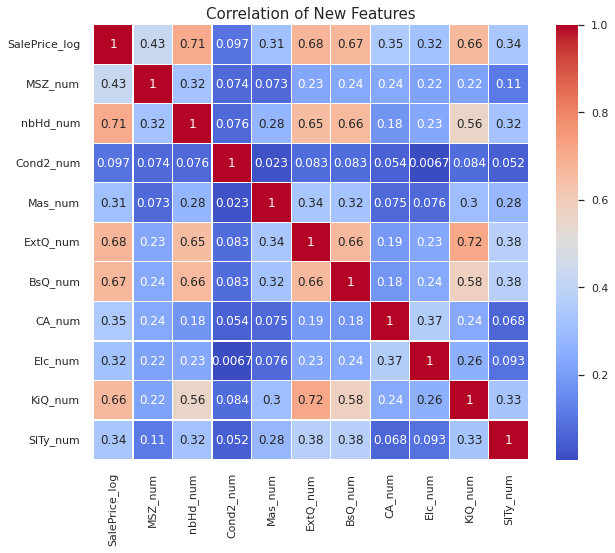

In [44]:
new_col_HM=train[['SalePrice_log','MSZ_num','nbHd_num','Cond2_num','Mas_num','ExtQ_num',
                  'BsQ_num','CA_num','Elc_num','KiQ_num','SlTy_num']]

colormap=plt.cm.coolwarm
plt.figure(figsize=(10,8))
plt.title('Correlation of New Features', y=1.0, size=15)
sns.heatmap(new_col_HM.corr(), linewidths=.2, vmax=1, square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={'size':12})

In [45]:
# 기존 범주형 변수와 새로 만들어 수치형 변수 역시 유의하지 않은 것들은 삭제한다.
train.drop(['MSZoning','Neighborhood','Condition2','MasVnrType','ExterQual','BsmtQual','CentralAir',
            'Electrical','KitchenQual','SaleType','Cond2_num','Mas_num','CA_num','Elc_num','SlTy_num'], axis=1, inplace=True)
test.drop(['MSZoning','Neighborhood','Condition2','MasVnrType','ExterQual','BsmtQual','CentralAir',
            'Electrical','KitchenQual','SaleType','Cond2_num','Mas_num','CA_num','Elc_num','SlTy_num'], axis=1, inplace=True)

train.head() # 완벽히 삭제되어 유의하다고 판단되는 수치형 변수만 남았다.

,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,GrLivArea,FullBath,GarageCars,SalePrice_log,MSZ_num,nbHd_num,ExtQ_num,BsQ_num,KiQ_num
0,7,2003,2003,856,1710,2,2,12.247694,3,2,3,2,3
1,6,1976,1976,1262,1262,2,2,12.109011,3,2,2,2,2
2,7,2001,2002,920,1786,2,2,12.317167,3,2,3,2,3
3,7,1915,1970,756,1717,1,3,11.849398,3,2,2,1,3
4,8,2000,2000,1145,2198,2,3,12.429216,3,3,3,2,3


# 4.Modeling & Make Submission
Model : XGBoost.Regressor

## 4-1.Validation

In [46]:
# test 하기 전 검증 과정을 거친다. 
X_train=train.drop('SalePrice_log', axis=1).values
Y_train=train['SalePrice_log'].values
X_test=test.values

x_train, x_valid, y_train, y_valid = train_test_split(X_train, Y_train, test_size=.2, random_state=2000)

## 4-2.Modeling

In [48]:
# XGBoost
regressor=xgboost.XGBRegressor(colsample_bytree=0.4603, learning_rate=0.06, min_child_weight=1.8,
                               max_depth=3, subsample=0.52, n_estimators=2000, random_state=7, nthread=-1)b
regressor.fit(x_train, y_train)

[05:22:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(colsample_bytree=0.4603, learning_rate=0.06, min_child_weight=1.8,
             n_estimators=2000, nthread=-1, random_state=7, subsample=0.52)

regressor socre : 0.9778929954593789


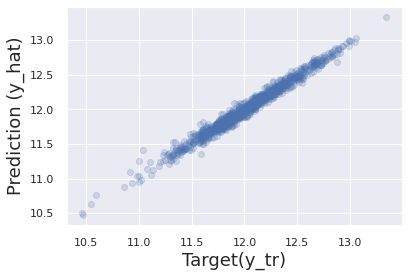

In [49]:
# 예측된 y값(y_hat)에 대한 Scatter Plot을 그려본다. 
y_hat=regressor.predict(x_train)

print(f"regressor socre : {regressor.score(x_train, y_train)}")
plt.scatter(y_train, y_hat, alpha=0.2)
plt.xlabel('Target(y_tr)',size=18)
plt.ylabel('Prediction (y_hat)', size=18)
plt.show()

## 4-3.Predict

Validate regressor score : 0.8387039163837681


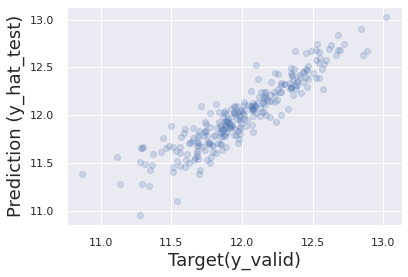

In [51]:
# Validation으로 예측
y_hat_test=regressor.predict(x_valid)

print(f"Validate regressor score : {regressor.score(x_valid, y_valid)}")
plt.scatter(y_valid, y_hat_test, alpha=.2)
plt.xlabel('Target(y_valid)', size=18)
plt.ylabel('Prediction (y_hat_test)', size=18)
plt.show()

## 4-4.KFold

In [54]:
accuracy=cross_val_score(estimator=regressor, X=x_train, y=y_train, cv=50)

[05:28:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:28:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:28:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:29:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:29:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:29:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:29:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:29:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [53]:
# 정확도 확인
print(accuracy.mean())
print(accuracy.std())

0.8463773269333027
0.033933803654181784


## 4-5.Submission

In [60]:
use_logvals=1
pred_xgb=regressor.predict(X_test)

preds={'Id':id_test,'SalePrice':pred_xgb}
sub_xgb=pd.DataFrame(preds)

if use_logvals==1:
    sub_xgb['SalePrice']=np.exp(sub_xgb['SalePrice'])

sub_xgb

,Id,SalePrice
0,1461,109063.921875
1,1462,132880.687500
2,1463,182313.062500
3,1464,177576.234375
4,1465,192665.656250
...,...,...
1454,2915,75933.453125
1455,2916,84156.632812
1456,2917,159560.265625
1457,2918,110286.945312
